In [1]:
from matplotlib import pyplot as plt

plt.rcParams['axes.labelsize'] = 14      # grandezza etichette assi (xlabel, ylabel)
plt.rcParams['xtick.labelsize'] = 12     # grandezza numeri asse x
plt.rcParams['ytick.labelsize'] = 12     # grandezza numeri asse y
plt.rcParams['legend.fontsize'] = 12     # grandezza testo legenda
plt.rcParams['axes.titlesize'] = 16      # grandezza titolo del grafico

In [2]:
from utils import debug, from_uM_to_molecules, from_molecules_to_uM
from deterministic_model import make_toggle_switch_ode, run_sim
from stochastic_model import make_toggle_switch_stochastic, check_if_switched, compute_percentage_switched, fit_and_plot_hill_function
from plot import plot_trajectories, plot_histograms_LacR

debug_flag=False

#### 1) Parametri e condizioni iniziali

In [3]:
###########################################################################
# Dati sperimetali
molecules_per_uM = 500 # molecole/uM : circa 500 molecole per avere una concentrazione molare di 1 uM


###########################################################################
#  Parameters
n = 3 # hill parameter

alpha_1 = 0.2 # uM/ min
alpha_2 = alpha_1 

beta_1 = 4 # uM/ min
beta_2 = beta_1 

K1 = 1 # uM
K2 = K1

d1_base = 1 # 1/min. Si chiama base perchè è il valore per istanti iniziali (fra 0 e 60 min). Dopodichè aumenta (vedi dopo)
d2 = d1_base

gamma = 1 # 1/min

epsilon = 1

s = 1.7  # adimensional



###########################################################################
# Initial conditions (numero di molecole!)
u_0_nmolecules = 2125 # λCI
v_0_nmolecules = 125 # LacR



# intial conditions in uM
u_0 = from_molecules_to_uM(u_0_nmolecules, molecules_per_uM)
v_0 = from_molecules_to_uM(v_0_nmolecules, molecules_per_uM)
print(f"Initial conditions: u_0 = {u_0:.2f} uM, v_0 = {v_0:.2f} uM")


###########################################################################
# MMC induction window
t_start_MMC = 60 # min
t_end_MMC = 960 # min


Initial conditions: u_0 = 4.25 uM, v_0 = 0.25 uM


**Riguardo al parametro d1:**

- d₁ è il tasso di degradazione della proteina λCI.

- Normalmente vale d₁ = 1 min⁻¹, ma quando la cellula subisce danno al DNA (indotto dalla mitomicina C, MMC) la proteina RecA si lega a λCI e ne aumenta la degradazione.

    - Prima e dopo l’induzione (t < 60 min o t > 960 min): d1 = d1_base = 1; 
    - Durante l’induzione (60 ≤ t ≤ 960 min): d1= d1_base + gamma*s / (1+s)
- Nel modello del paper la prima ora (t < 60 min) serve per far stabilizzare il sistema nello stato iniziale ad alto λCI. Invece il trattamento con MMC dura 15h, per questo dopo 960 min d1 torna al livello base

#### 2) Modello deterministico


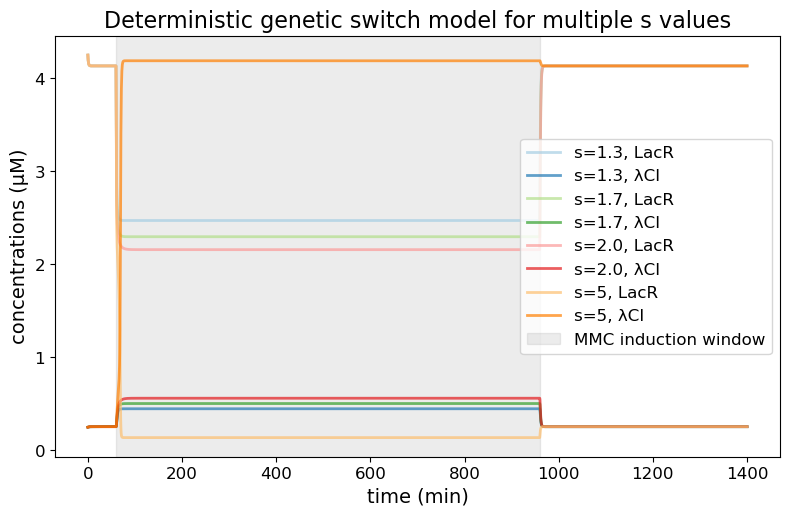

In [4]:
ode_system = make_toggle_switch_ode(alpha_1, beta_1, alpha_2, beta_2, K1, K2, d1_base, n, d2, gamma, epsilon)

t_sim = [0, 1400] # simulation time (min)
y0 = [u_0, v_0] # initial conditions in uM
delta_t = 0.5

# Try a few s values 
s_values = [1.3, 1.7, 2.0, 5]
sims = [run_sim(s, ode_system, y0, t_sim, delta_t) for s in s_values]

plot_trajectories(s_values, sims, filename="results/fig2_deterministic_multiple_s_values.svg")

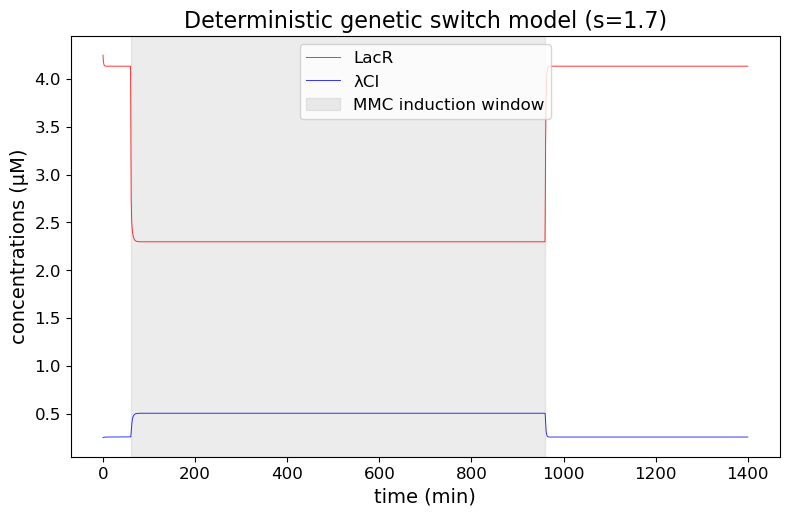

In [5]:
s_values = [1.7]
sims = [run_sim(s, ode_system, y0, t_sim, delta_t) for s in s_values]

plot_trajectories(s_values, sims, filename="results/fig2_deterministic.svg")

The deterministic model switches only for very big value of $s$!

#### 3) Modello stocastico

Riguardo la **post-leap check strategy**:


Con il tau-leap “puro” può capitare che le reazioni di degradazione sottraggano più molecole di quante ce ne sono a disposizione, portando a valori negativi. Una delle strategie standard usate nella pratica per evitarlo è il *Post-leap check + riduzione adattiva di τ*:

- Fai il leap;
- Se $u_{k+1}<0$ o $v_{k+1}<0$ annulla quello step, dimezza τ e riesegui il campionamento. Ripeti finché non hai aggiornamenti validi (o fino a un minimo τ).

Simulation 1


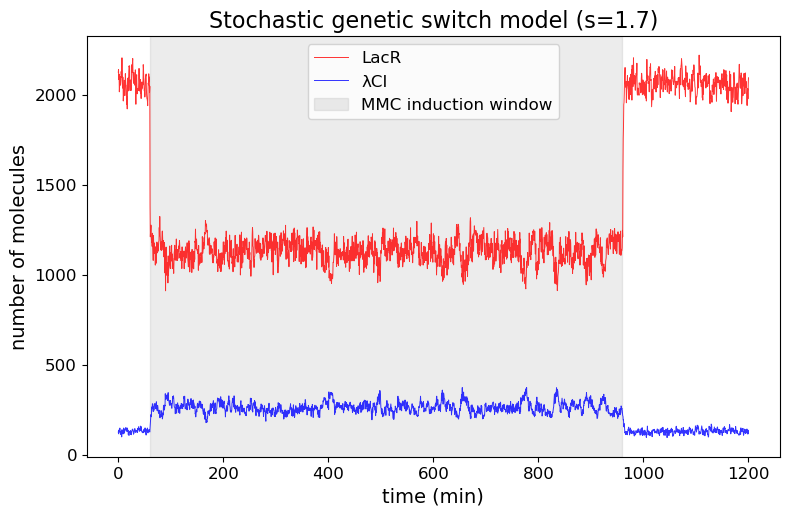

Simulation 2


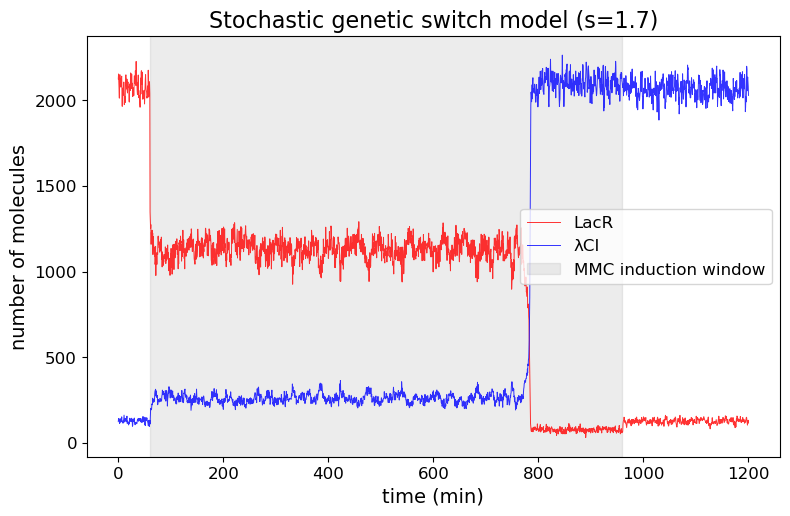

Simulation 3


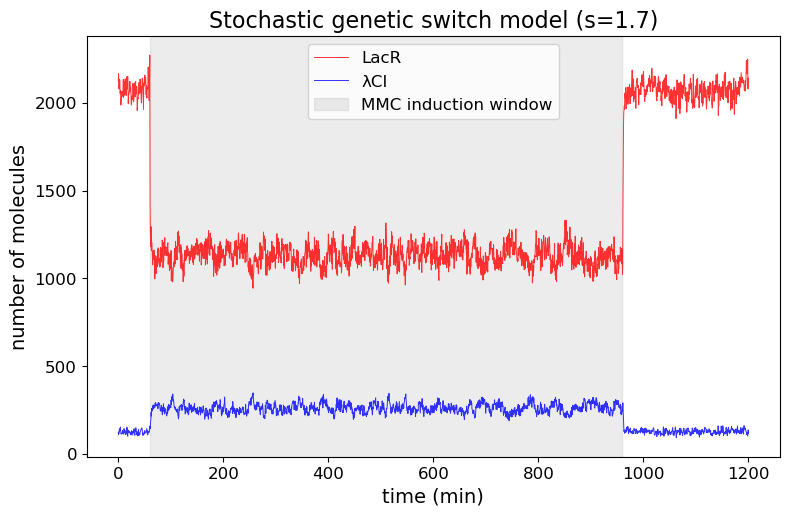

Simulation 4


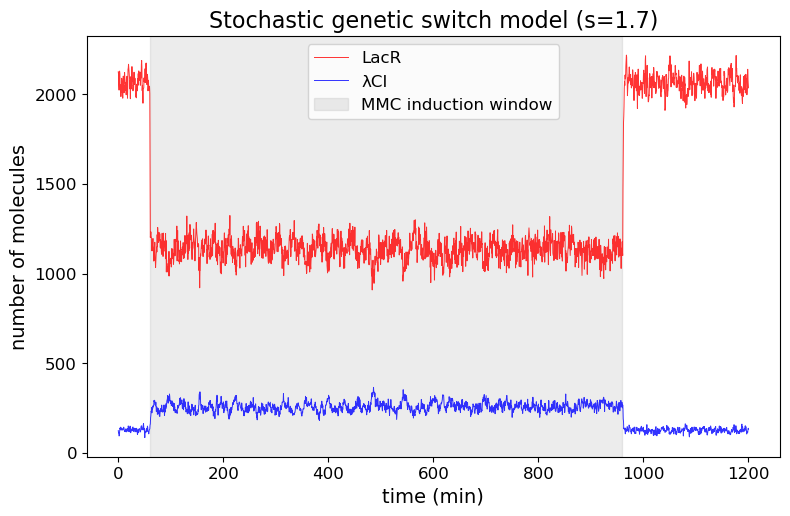

Simulation 5


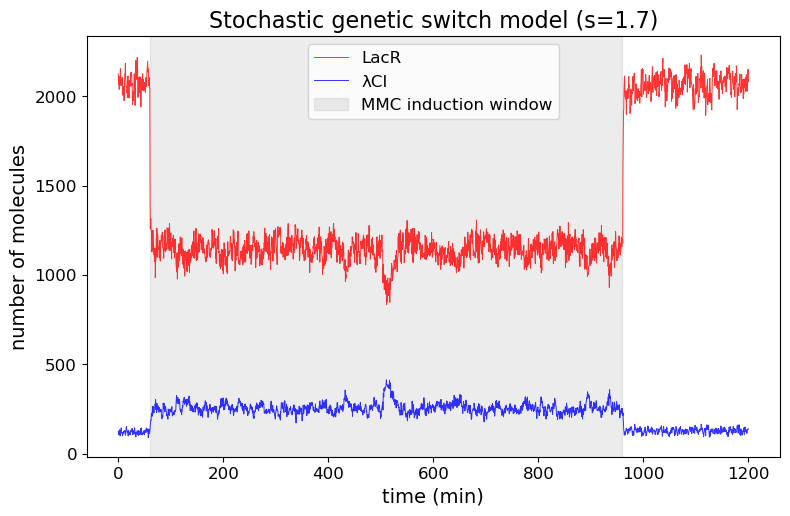

Simulation 6


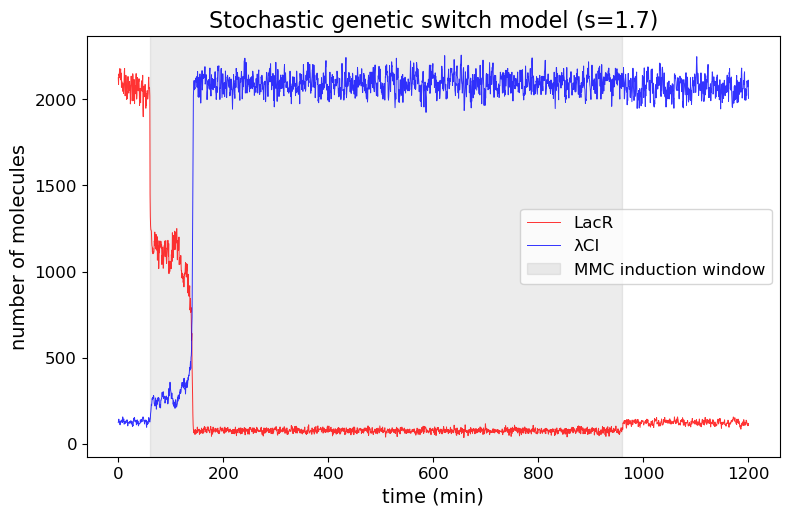

Simulation 7


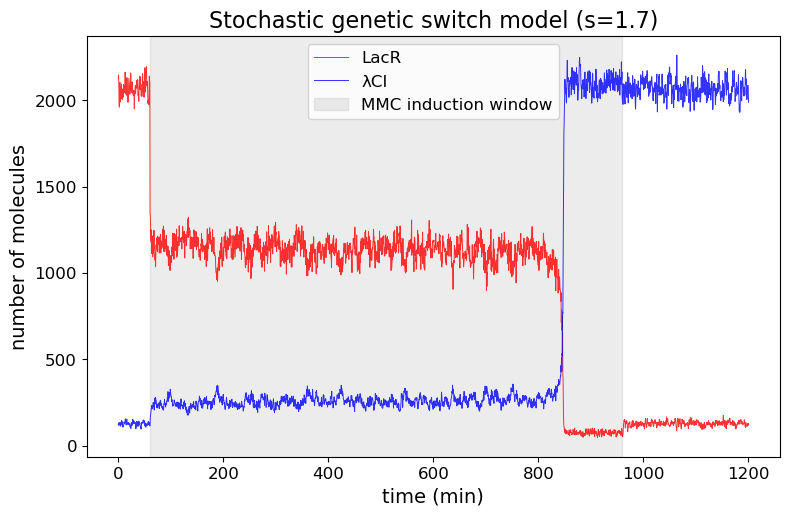

Simulation 8


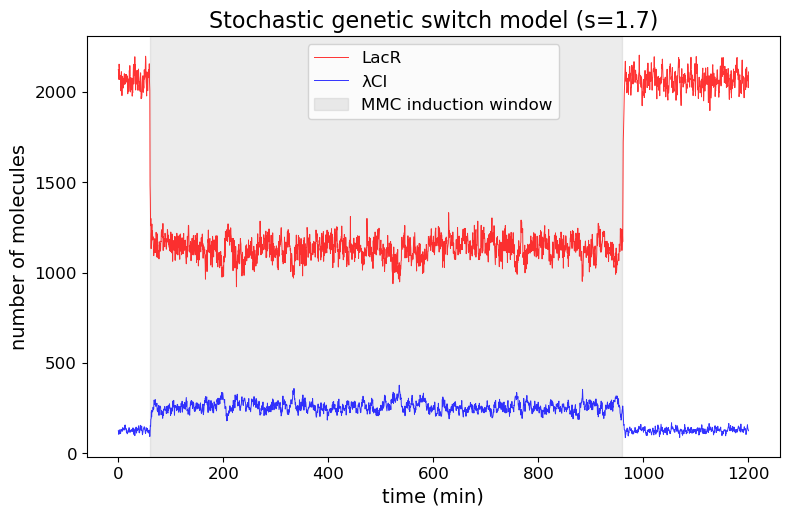

Simulation 9


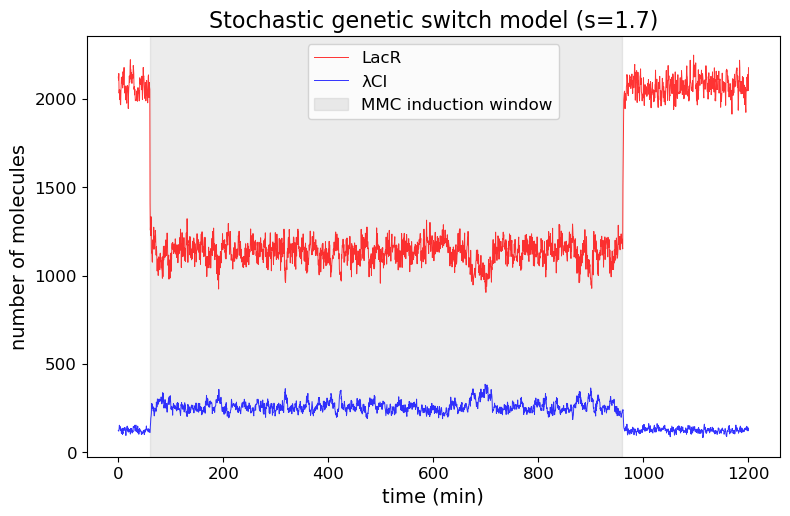

Simulation 10


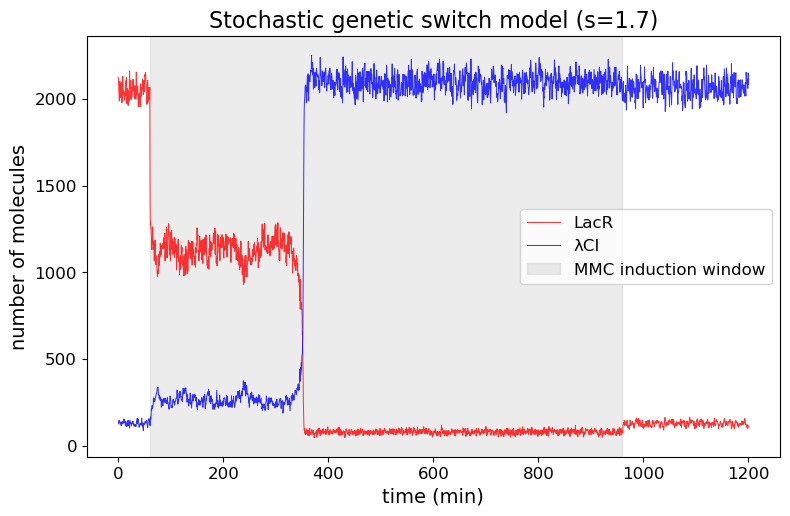

In [6]:
stochastic_model = make_toggle_switch_stochastic(alpha_1, beta_1, alpha_2, beta_2, K1, K2, 
                                                 d1_base, n, d2, gamma, epsilon, u_0_nmolecules, v_0_nmolecules, debug_flag)

# Try a few s values around the reported threshold range
s_values = [1.7]
tau = 0.5

# Running multiple simulations with the same initial conditions and parameters
# to see the variability of the results due to the stochastic nature of the model
N_trials = 10
for i in range(N_trials):
    print(f"Simulation {i+1}")
    sims = [stochastic_model(tau, s) for s in s_values]
    plot_trajectories(s_values, sims, filename=f"results/fig2_stochastic_trial_{i+1}.svg")



Nel caso stocastico si ottiene lo switch anche con valori di s più piccoli (rispetto al caso deterministico). Inoltre lo switch può avvenire o meno con la stessa configurazione dei parametri iniziali!

#### 3.1) Istogramma LacR al variare di s (Fig 3)

Simulation 1
The system has NOT switched:
	last 200 samples averages:
		u=2059.7,
		v=129.2


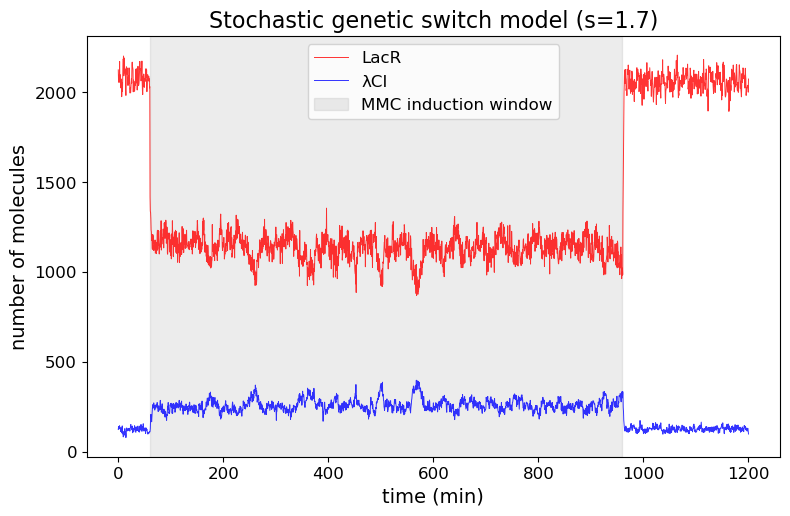

Simulation 2
The system has NOT switched:
	last 200 samples averages:
		u=2061.5,
		v=130.0


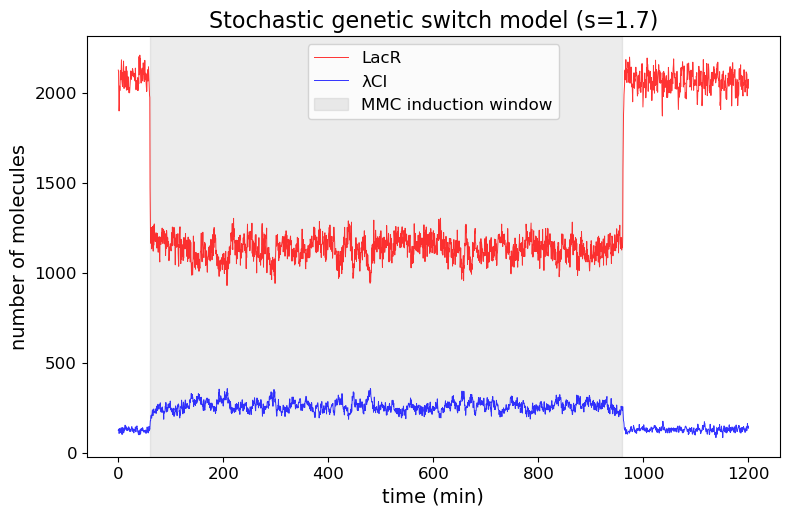

Simulation 3
The system has switched:
	last 200 samples averages:
		u=129.1,
		v=2072.2


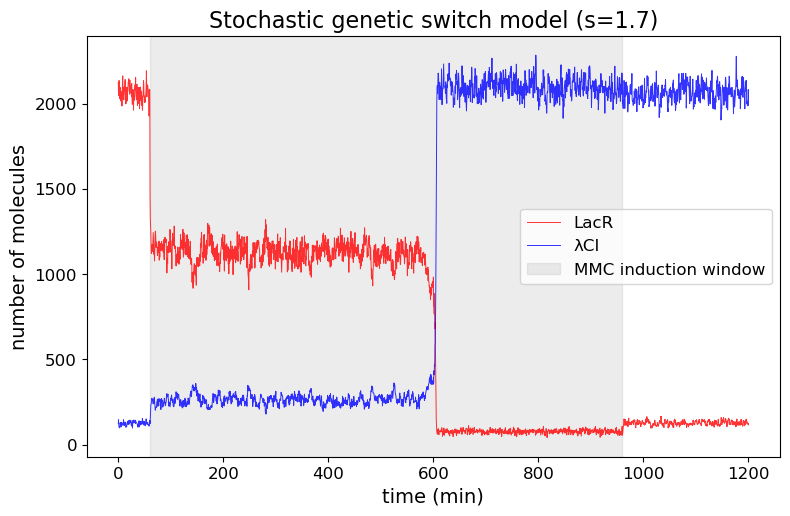

Simulation 4
The system has NOT switched:
	last 200 samples averages:
		u=2071.6,
		v=127.4


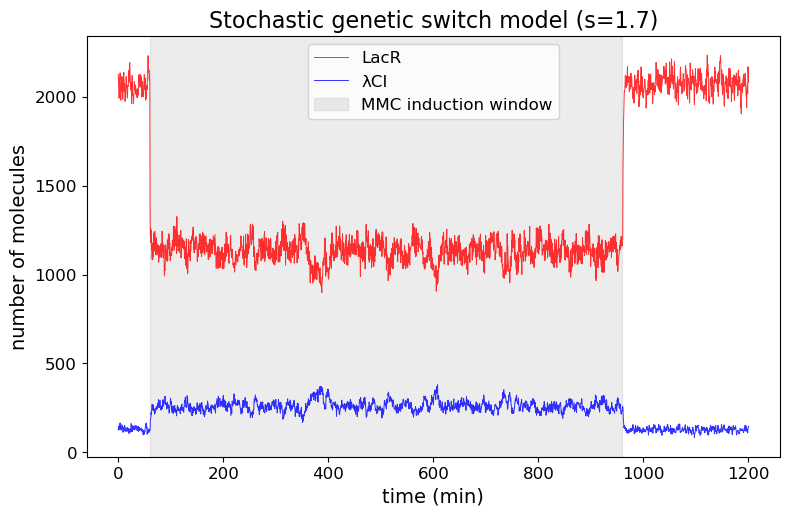

Simulation 5
The system has switched:
	last 200 samples averages:
		u=127.9,
		v=2074.8


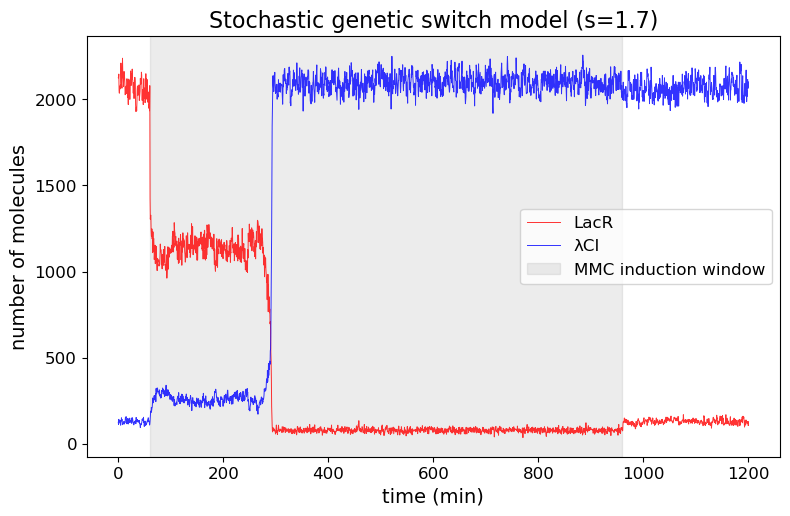

Simulation 6
The system has switched:
	last 200 samples averages:
		u=127.9,
		v=2059.2


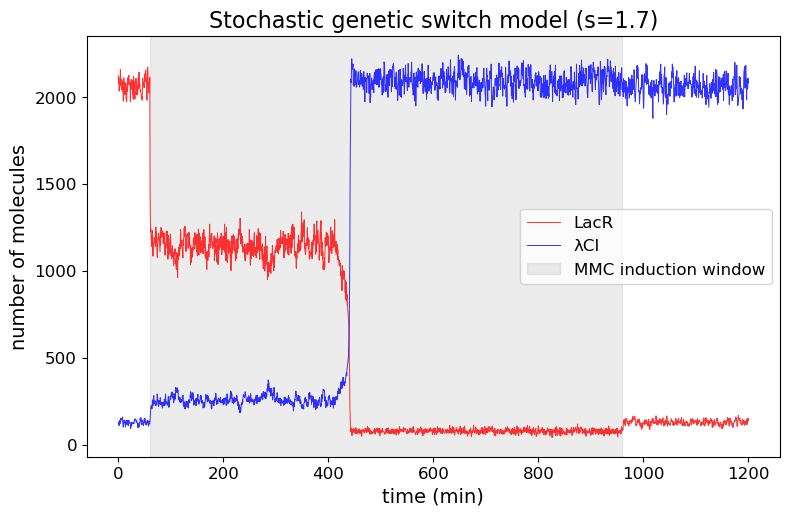

Simulation 7
The system has switched:
	last 200 samples averages:
		u=127.3,
		v=2067.6


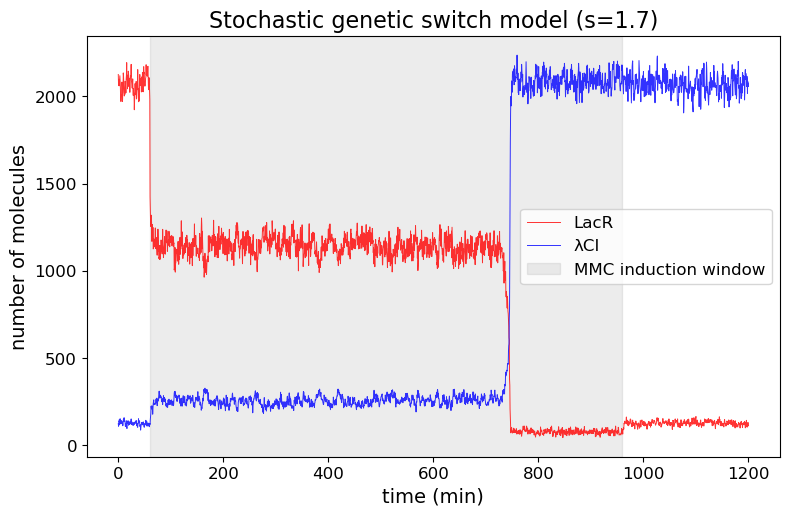

Simulation 8
The system has NOT switched:
	last 200 samples averages:
		u=2067.4,
		v=130.7


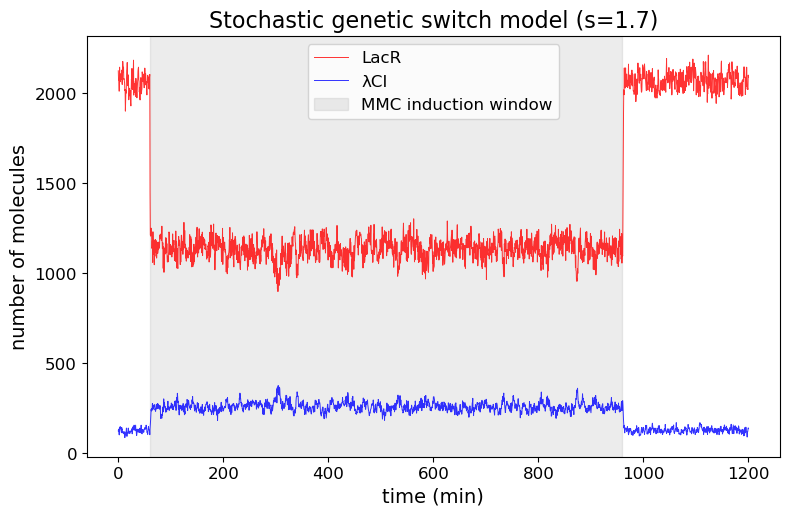

Simulation 9
The system has switched:
	last 200 samples averages:
		u=127.2,
		v=2068.2


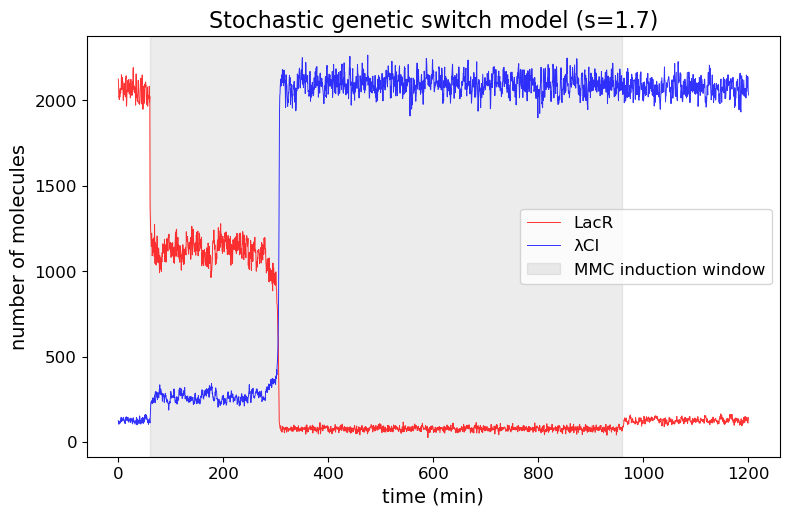

Simulation 10
The system has NOT switched:
	last 200 samples averages:
		u=2065.9,
		v=127.0


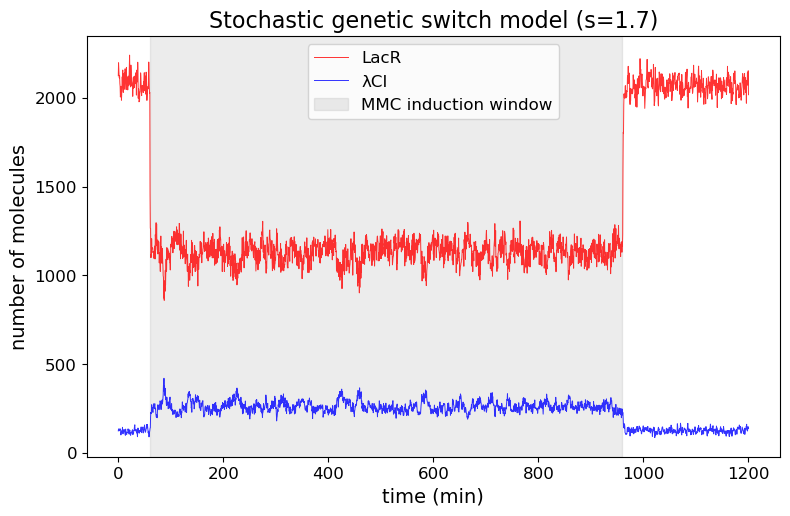

In [8]:
stochastic_model = make_toggle_switch_stochastic(alpha_1, beta_1, alpha_2, beta_2, K1, K2, 
                                                 d1_base, n, d2, gamma, epsilon, u_0_nmolecules, v_0_nmolecules, debug_flag)

# Try a few s values around the reported threshold range
s = 1.7
tau = 0.5

# Running multiple simulations with the same initial conditions and parameters
# to see the variability of the results due to the stochastic nature of the model
N_trials = 10
for i in range(N_trials):
    print(f"Simulation {i+1}")
    sim = stochastic_model(tau, s) 
    check_if_switched(sim, molecules_per_uM, debug_flag=True)
    plot_trajectories([s], [sim], save_plot=False)
    #print("_____________________________________")

Now we try to compute the histogram from Fig.3 of the paper



Running simulations for s=1.3
Running simulations for s=1.7
Running simulations for s=1.75
Running simulations for s=2.0


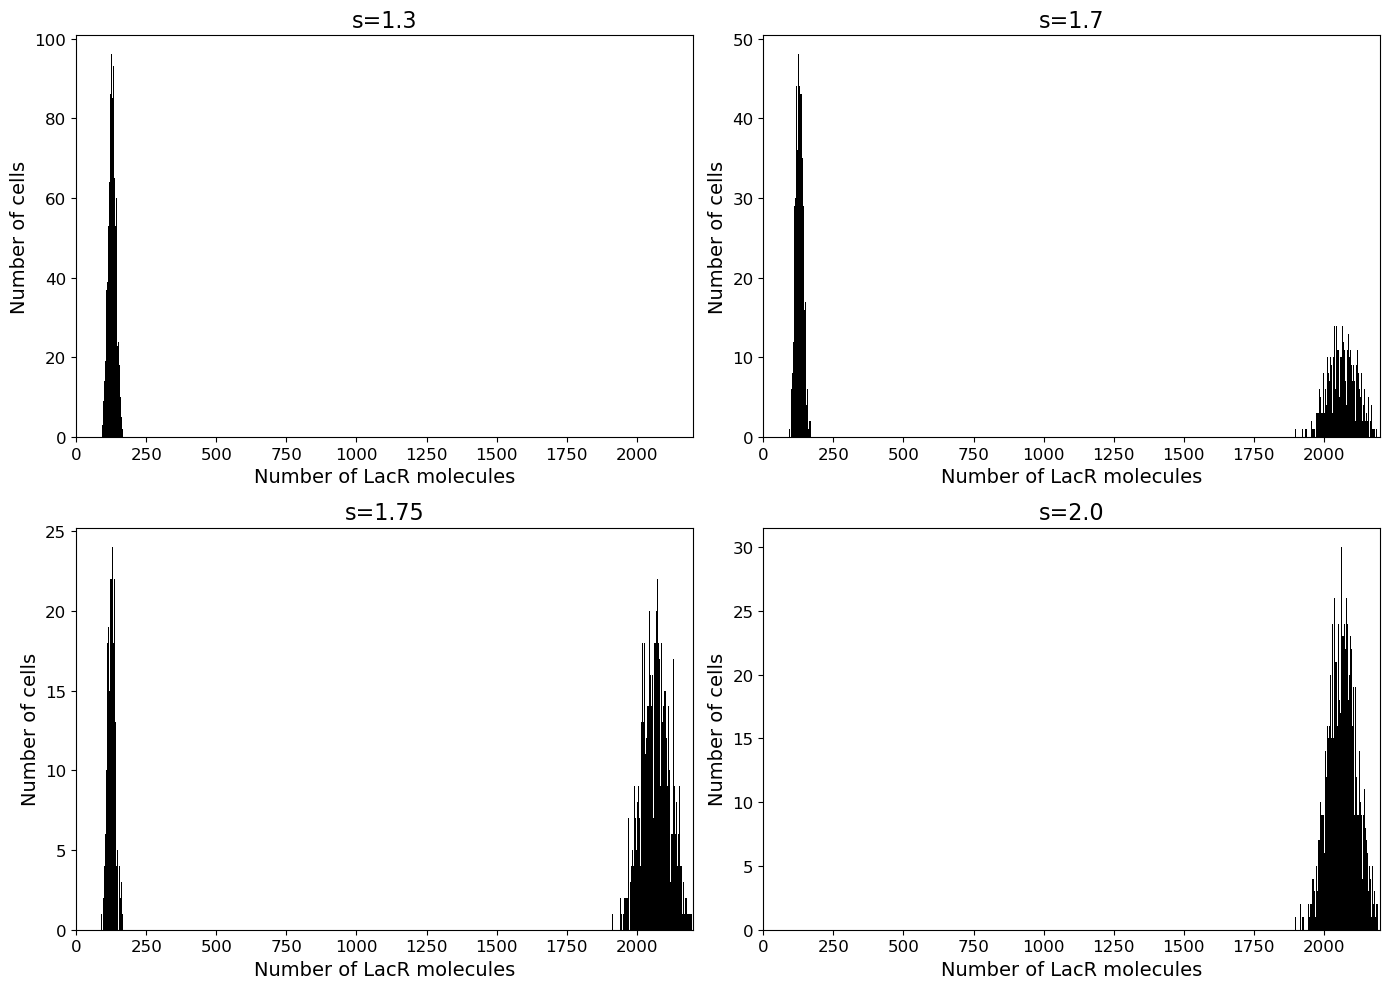

In [9]:
stochastic_model = make_toggle_switch_stochastic(alpha_1, beta_1, alpha_2, beta_2, K1, K2, 
                                                    d1_base, n, d2, gamma, epsilon, u_0_nmolecules, v_0_nmolecules, debug_flag)


plot_histograms_LacR(stochastic_model)

<span style="color:red">TODO: sovraimporre la curva sperimentale</span>


#### 3.1) Curva di hill al variare di s (Fig 2d)

In [10]:
stochastic_model = make_toggle_switch_stochastic(alpha_1, beta_1, alpha_2, beta_2, K1, K2, 
                                                 d1_base, n, d2, gamma, epsilon, u_0_nmolecules, v_0_nmolecules, debug_flag)

result_df=compute_percentage_switched(stochastic_model, tau) 


Running simulations for s=1.5
	Percentage of switched systems for s=1.5: 0.40%

Running simulations for s=1.525
	Percentage of switched systems for s=1.525: 1.50%

Running simulations for s=1.55
	Percentage of switched systems for s=1.55: 2.80%

Running simulations for s=1.575
	Percentage of switched systems for s=1.575: 4.70%

Running simulations for s=1.6
	Percentage of switched systems for s=1.6: 11.30%

Running simulations for s=1.625
	Percentage of switched systems for s=1.625: 16.50%

Running simulations for s=1.65
	Percentage of switched systems for s=1.65: 23.40%

Running simulations for s=1.675
	Percentage of switched systems for s=1.675: 34.70%

Running simulations for s=1.7
	Percentage of switched systems for s=1.7: 46.70%

Running simulations for s=1.725
	Percentage of switched systems for s=1.725: 62.90%

Running simulations for s=1.75
	Percentage of switched systems for s=1.75: 77.80%

Running simulations for s=1.7750000000000001
	Percentage of switched systems for s=1.77

In [13]:
result_df


,s,percentage_switched
0,1.500,0.4
1,1.525,1.5
2,1.550,2.8
3,1.575,4.7
4,1.600,11.3
5,1.625,16.5
6,1.650,23.4
7,1.675,34.7
8,1.700,46.7
9,1.725,62.9


Fit base: A=1.2277, B=0.2478, s0=1.4739, n=4
Scaled A to hit p(s_ref=1.850)=99.40% -> A=1.2277


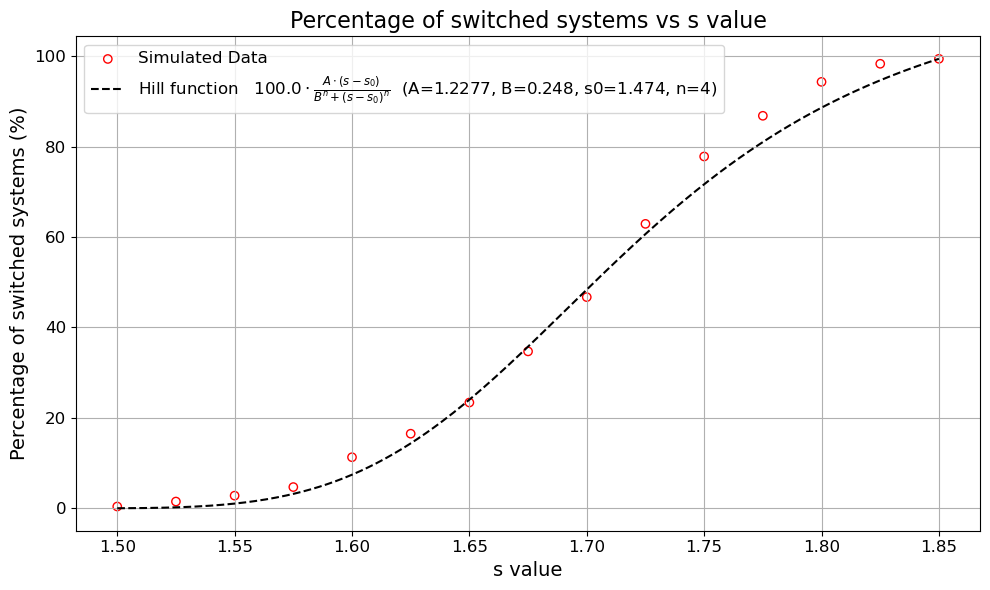

In [14]:
fit_and_plot_hill_function()
